#**Analyse des données images**

###**Les librairies utiles**

In [ ]:
# Import des librairies de base
import os
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD

from tqdm import tqdm
import time #
from PIL import Image, ImageOps # ouvrir, manipuler et enregistrer différents formats d'images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings #
import cv2 # "OpenCV"  : traitement d'images et la détection de caractéristiques
# Prétraitement des Images et extraction de Caractéristiques
from keras.applications import VGG16, vgg16, ResNet50, resnet, InceptionV3, inception_v3

###**Dossier de travail**

In [ ]:
# Connecter à googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Choisir le répertoire
dir = os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P6_Classification_automatiquement_des_biens/data')

In [ ]:
data = pd.read_csv('data_propre.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

###**Fonctions de Clustering et Réduction de dimensions**

In [ ]:

def select_n_components(features, goal_var: float) -> int:
    """
    La méthode PCA de sklearn permet de selectionner un float en n_compoents afin de ne garder que
    0.99 (par ex) de la variance totale mais cela n'est pas possible pour la méthode SVD.
    Cette function permet de récupérer le nombre de composantes expliquant X%  de la variance totale
    par la méthode de réduction SVD.
    """

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components = features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

####################################################################################
# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données
    avec le choix de l'algorithme de réduction dans les arguments : SVD, UMAP ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

####################################################################################

def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les
        vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après t-sne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


####################################################################################
def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show();

###**Chargement et détection des invariants**

In [ ]:
# Chemin vers les données images
path_to_image = "Flipkart/Images/"
image_files  = [file for file in listdir(path_to_image)]
print(len(image_files))

1050


**Encodage des catégories**

In [ ]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["Categ_A"])

In [ ]:
data[['Categ_A', 'label']].value_counts()

Categ_A                      label
Baby Care                    0        150
Beauty and Personal Care     1        150
Computers                    2        150
Home Decor & Festive Needs   3        150
Home Furnishing              4        150
Kitchen & Dining             5        150
Watches                      6        150
Name: count, dtype: int64

**Le jeu de données est équilibré**

#### **Exemples de descripteurs**

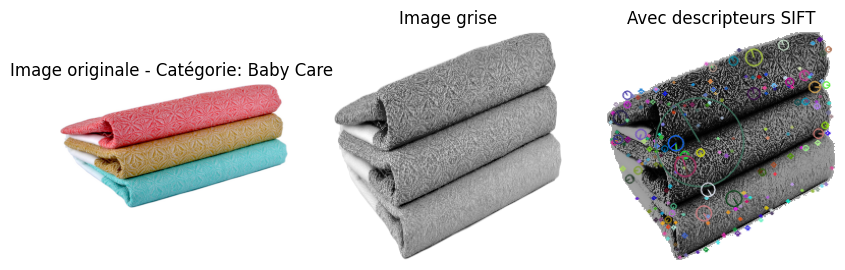

Nombre de descripteurs détectés : 231
Dimensions des descripteurs : 128


In [ ]:
# Initialiser SIFT
sift = cv2.SIFT_create()

# On sélectionne le premier article
article = data.iloc[1]
category = article['Categ_A']
# chemin vers l'image
image_path = path_to_image + article['image']

# Charger l'image en niveaux de gris
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("L'image n'a pas pu être chargée. Vérifie le chemin de l'image.")

# Redimensionner pour une analyse plus rapide
image_resized = cv2.resize(image, (224, 224))

# Égalisation de l'histogramme
image_equalized = cv2.equalizeHist(image_resized)

# Détection des points clés et calcul des descripteurs
keypoints, descriptors = sift.detectAndCompute(image_equalized, None)

# Dessiner les points clés sur l'image
image_with_keypoints = cv2.drawKeypoints(image_equalized
                                         , keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Affichage de l'image originale et de celle avec les points clés détectés
plt.figure(figsize=(10, 15))

plt.subplot(1, 3, 1)
# Image originale
plt.title(f"Image originale - Catégorie: {category}")
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')

# Image originale en gris
plt.subplot(1, 3, 2)
plt.title("Image grise")
plt.imshow(image_resized, cmap='gray')
plt.axis('off')

# Image avec descripteurs SIFT
plt.subplot(1, 3, 3)
plt.title("Avec descripteurs SIFT")
plt.imshow(image_with_keypoints, cmap='gray')
plt.axis('off')

plt.show();

# Afficher les descripteurs pour un aperçu
print("Nombre de descripteurs détectés :", descriptors.shape[0])
print("Dimensions des descripteurs :", descriptors.shape[1])
# print("Exemple de descripteur :", descriptors[0])

####**Les descripteurs**

In [ ]:
# Paramètres
num_clusters = 50  # Nombre de clusters pour K-means

# Collection de tous les descripteurs de chaque image
all_descriptors = []

start_time = time.time()
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
for i in tqdm(range(len(data))):
    # Charger et traiter chaque image
    image_path = path_to_image + data.iloc[i]['image']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        continue  # Ignorer les images non trouvées

    image = cv2.resize(image, (299, 299))
    image = cv2.equalizeHist(image)

    # Extraire les descripteurs SIFT
    _, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        all_descriptors.extend(descriptors)

# Conversion en tableau NumPy pour traitement
all_descriptors = np.array(all_descriptors)

# Afficher le nombre de descripteurs collectés
print("Nombre total de descripteurs extraits :", all_descriptors.shape[0])

# Étape 1: Réduction de dimension avec PCA
print("Réduction de dimension avec PCA...")
# pca = PCA(n_components=num_components)
pca = PCA(n_components=.99, random_state=22)
descriptors_reduced = pca.fit_transform(all_descriptors)

# Étape 2: Clustering avec K-means
print("Clustering avec K-means...")
# num_clusters = int(round(np.sqrt(len(all_descriptors)), 0))         # Nombre de clusters pour K-means
kmeans = KMeans(n_clusters = num_clusters, random_state=42, n_init=10)
kmeans.fit(descriptors_reduced)

# Résultats
print("\nClustering terminé.")
print("Nombre total de descripteurs:", len(all_descriptors))
print("Nombre de clusters:", num_clusters)
# print("Exemple de centres de clusters (format réduit):\n", kmeans.cluster_centers_[:5])

duration = time.time() - start_time
print(f"Temps total de traitement : {duration:.2f} secondes")


100%|██████████| 1050/1050 [02:06<00:00,  8.28it/s]


Nombre total de descripteurs extraits : 550948
Réduction de dimension avec PCA...
Clustering avec K-means...

Clustering terminé.
Nombre total de descripteurs: 550948
Nombre de clusters: 50
Temps total de traitement : 1022.25 secondes


**Le nombre de clusters estimés**

In [ ]:
k = int(round(np.sqrt(len(all_descriptors)), 0))
print("Nombre de clusters estimés : ", k)

Nombre de clusters estimés :  742


#####**Création d'histogrammes de cluster par images**

In [ ]:
# Liste pour stocker les histogrammes des clusters pour chaque image
histograms = []

# Repartir les descripteurs en histogrammes par image
descriptor_idx = 0  # index des descripteurs cumulés

for i in range(len(data)):
    image_path = path_to_image + data.iloc[i]['image']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        # Si l'image n'est pas trouvée, on ajoute un histogramme vide
        histograms.append(np.zeros(num_clusters))
        continue

    # Redimensionner et égaliser l'histogramme de l'image pour SIFT
    image = cv2.resize(image, (299, 299))
    image = cv2.equalizeHist(image)

    # Extraire les descripteurs de l'image
    _, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        # Réduire la dimension des descripteurs avec le PCA déjà ajusté
        descriptors_reduced = pca.transform(descriptors)
        # Prédire les clusters pour ces descripteurs
        cluster_labels = kmeans.predict(descriptors_reduced)
        # Construire un histogramme des clusters pour cette image
        histogram, _ = np.histogram(cluster_labels, bins=np.arange(num_clusters + 1), density=True)
        histograms.append(histogram)
    else:
        # Aucun descripteur trouvé pour l'image, on ajoute un histogramme de zéros
        histograms.append(np.zeros(num_clusters))

# On onvertie les histogrammes en tableau NumPy pour la suite de l'analyse
histograms = np.array(histograms)


#####**Clustering et similarité entre les vrais labels et prédictions**

In [ ]:
ARI_results = np.empty(shape=[0, 3])

ARI, labels = kmeans_fct(histograms, data['Categ_A'])
# Le poids du fichier en mémoire (1024 en ko et sur 1024² Mo)
# histograms.nbytes/1024
ARI_results = np.append(ARI_results, [["SIFT", "None", ARI]], axis=0)

ARI :  0.0528


**Une faible similarité entre les prédictions et les vrais labels.**

Nous allons utiliser les techniques de reduction de dimmensions  (**ACP**, **t-SNE**) pour optimiser les clusters.

####**Reduction de dimmension avec ACP**

In [ ]:
pca = PCA(n_components = 0.99, random_state=42)
pca.fit(histograms)
x = pca.transform(histograms)

print(f"Nombre de composents avant ACP: {histograms.shape[1]}")
print(f"Nombre de composents après ACP: {pca.n_components_}")
# histograms.nbytes
ARI, labels = kmeans_fct(x, data['Categ_A'])

ARI_results = np.append(ARI_results, [["SIFT", "PCA", ARI]], axis=0)

Nombre de composents avant ACP: 50
Nombre de composents après ACP: 43
ARI :  0.0529


#####**Matrice de confusion ACP**

In [ ]:
from sklearn.metrics import confusion_matrix
# Encodage des catégories en labels numériques
le = LabelEncoder()
vrai_labels = le.fit_transform(data['Categ_A'])
# la matrice de confusion
conf_mat_acp = confusion_matrix(vrai_labels, labels)

[6 2 3 5 4 4 2]


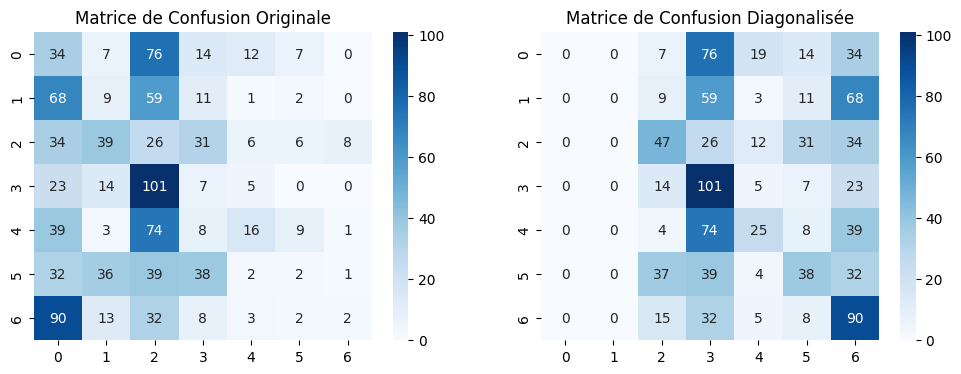

In [ ]:
# On transforme la matrice de confusion en dataframe
df_cm = pd.DataFrame(conf_mat_acp, index = [i for i in "0123456"],
                  columns = [i for i in "0123456"])

# Obtenir les indices des valeurs maximales par colonne
indices_max_col = np.argmax(conf_mat_acp, axis=0)
print(indices_max_col)
# Créer une matrice de confusion vide avec la même forme que l'originale
conf_mat_acp_diagonalized = np.zeros_like(conf_mat_acp)

# Réarranger les colonnes en fonction des indices max
for col in range(conf_mat_acp.shape[1]):
    row = indices_max_col[col]
    conf_mat_acp_diagonalized[:, row] += conf_mat_acp[:, col]

# Créer un DataFrame pandas pour la matrice diagonalisée
df_cm_diagonalized = pd.DataFrame(conf_mat_acp_diagonalized, index=[i for i in "0123456"],
                                   columns=[i for i in "0123456"])

# Créer une figure avec deux sous-graphiques côte à côte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # Premier sous-graphique
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Originale')

plt.subplot(1, 2, 2)  # Deuxième sous-graphique
sns.heatmap(df_cm_diagonalized, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Diagonalisée')
plt.show();

####**Reduction de dimmension avec t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.066


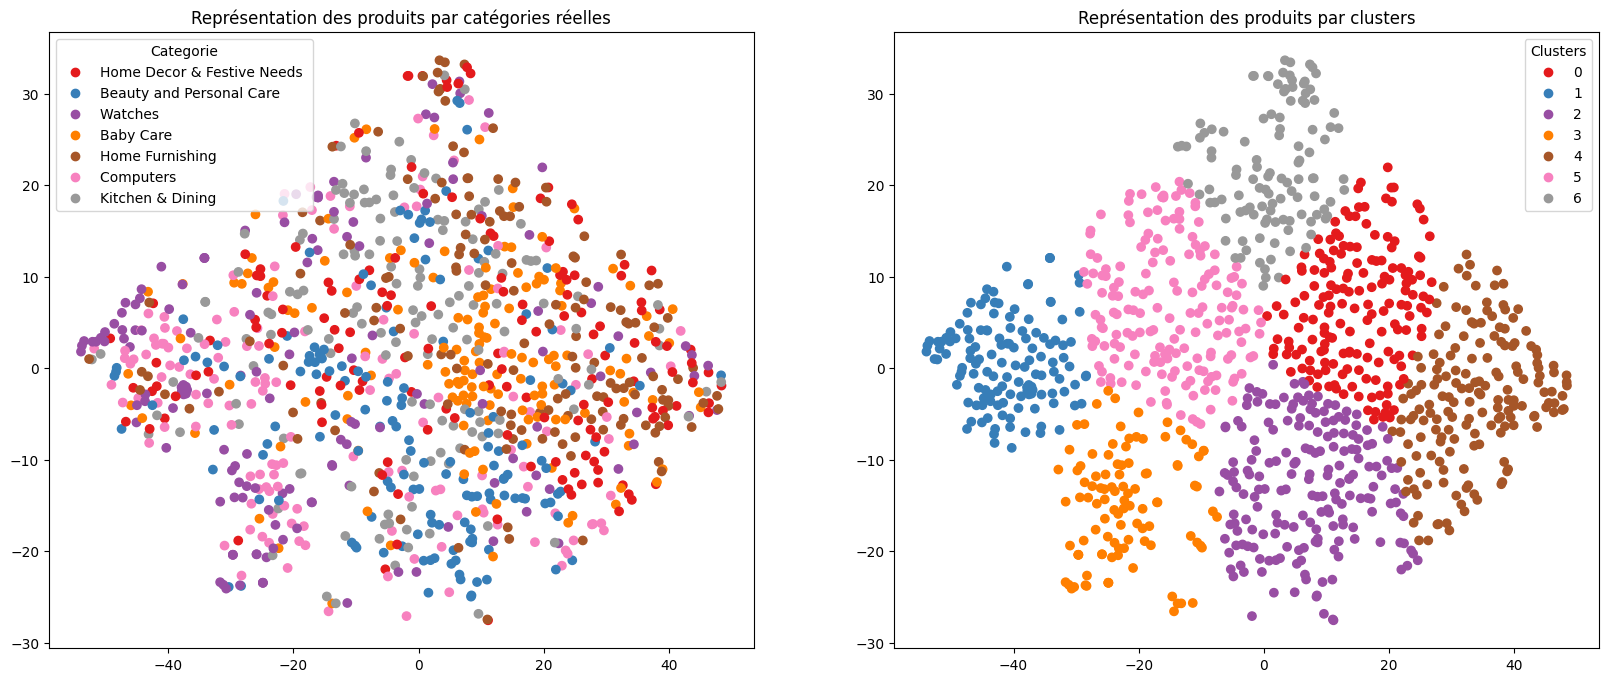

In [ ]:
# Réduction avec t-sne
X_reduc = reduction_fct(histograms, reduc='TSNE')
# On applque la fonction kmeans
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
# Visualisation es clusters
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["SIFT", "TSNE", ARI]], axis=0)

#####**Matrice de confusion t-SNE** : Analyse par classe

In [ ]:
conf_mat_tsne = confusion_matrix(vrai_labels, labels)

[3 2 1 2 4 6 6]


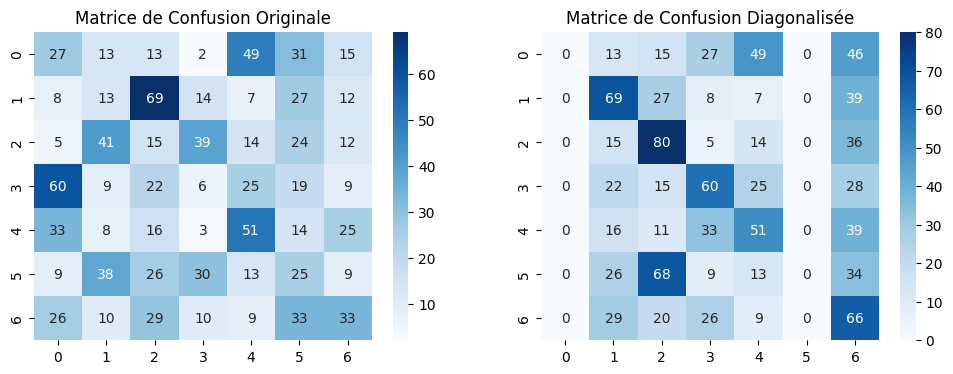

In [ ]:
df_cm = pd.DataFrame(conf_mat_tsne, index = [i for i in "0123456"], columns = [i for i in "0123456"])

# Obtenir les indices des valeurs maximales par colonne
indices_max_col = np.argmax(conf_mat_tsne, axis=0)
print(indices_max_col)
# Créer une matrice de confusion vide avec la même forme que l'originale
conf_mat_tsne_diagonalized = np.zeros_like(conf_mat_tsne)

# Réarranger les colonnes en fonction des indices max
for col in range(conf_mat_tsne.shape[1]):
    row = indices_max_col[col]
    conf_mat_tsne_diagonalized[:, row] += conf_mat_tsne[:, col]

# Créer un DataFrame pandas pour la matrice diagonalisée
df_cm_diagonalized = pd.DataFrame(conf_mat_tsne_diagonalized, index=[i for i in "0123456"]
                                  , columns=[i for i in "0123456"])

# Créer une figure avec deux sous-graphiques côte à côte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # Premier sous-graphique
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Originale')

plt.subplot(1, 2, 2)  # Deuxième sous-graphique
sns.heatmap(df_cm_diagonalized, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Diagonalisée')
plt.show();

####**Reduction de dimmension avec ACP et t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0639


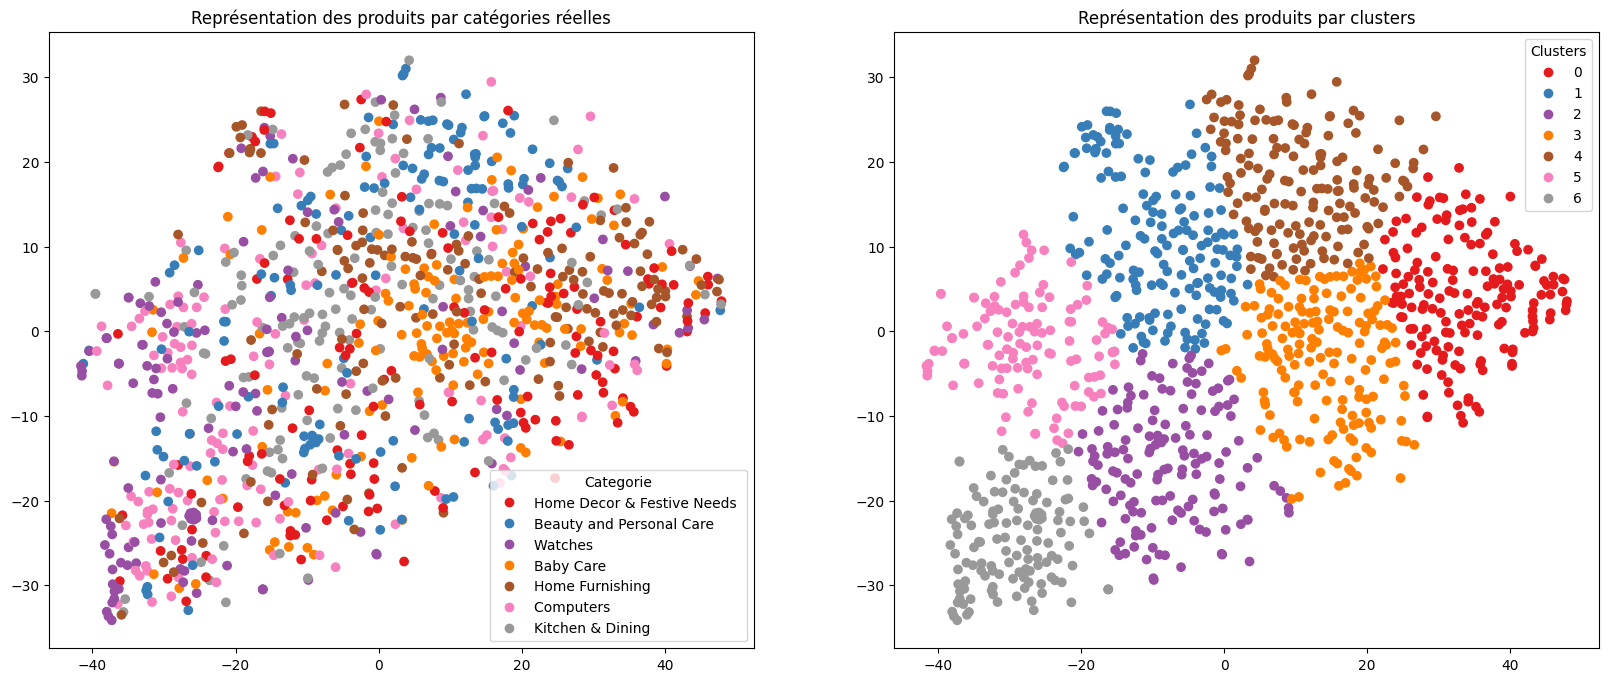

In [ ]:
# PCA + TSNE + kmeans
X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["SIFT", "PCA-TSNE", ARI]], axis=0)

#####**Matrice de confusion acp_tsne**

In [ ]:
conf_mat_acp_tsne = confusion_matrix(vrai_labels, labels)

[4 6 0 3 1 2 2]


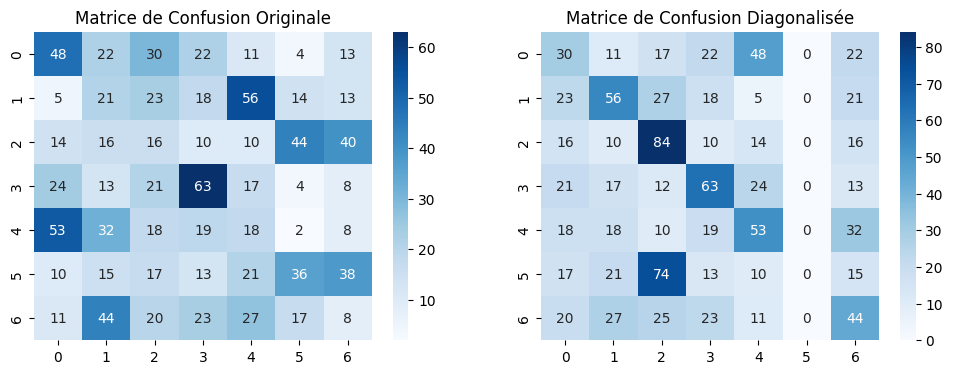

In [ ]:
df_cm = pd.DataFrame(conf_mat_acp_tsne, index = [i for i in "0123456"], columns = [i for i in "0123456"])

# Obtenir les indices des valeurs maximales par colonne
indices_max_col = np.argmax(conf_mat_acp_tsne, axis=0)
print(indices_max_col)
# Créer une matrice de confusion vide avec la même forme que l'originale
conf_mat_acp_tsne_diagonalized = np.zeros_like(conf_mat_acp_tsne)

# Réarranger les colonnes en fonction des indices max
for col in range(conf_mat_acp_tsne.shape[1]):
    row = indices_max_col[col]
    conf_mat_acp_tsne_diagonalized[:, row] += conf_mat_acp_tsne[:, col]

# Créer un DataFrame pandas pour la matrice diagonalisée
df_cm_diagonalized = pd.DataFrame(conf_mat_acp_tsne_diagonalized, index=[i for i in "0123456"], columns=[i for i in "0123456"])

# Créer une figure avec deux sous-graphiques côte à côte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # Premier sous-graphique
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Originale')

plt.subplot(1, 2, 2)  # Deuxième sous-graphique
sns.heatmap(df_cm_diagonalized, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Diagonalisée')
plt.show();

###**CNN Transfer Learning**

####Avec **VGG16**

In [ ]:
# La version pré-entraînée du modèle est déjà importée

# Chargement du Modèle
VGG16_model = VGG16(include_top = True, weights="imagenet", input_tensor=None
                    , input_shape=(224, 224, 3), pooling=None, classes=1000)

VGG16_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

#####**Prétraitement et extraction de Caractéristiques**

In [ ]:
from keras.applications import vgg16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

warnings.simplefilter('ignore', Image.DecompressionBombWarning)


In [ ]:
X = []
for image_num in tqdm(range(len(image_files))):
    # Extraire les features et mettre à jour le dictionnaire
    img = load_img(path_to_image + data["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg16.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████| 1050/1050 [00:23<00:00, 45.07it/s]


#####**Utilisation du modèle pour générer les features**

In [ ]:
# Utilisation du modèle pour générer les features
from keras.models import Model

# Paramètres
# include_top = False    # Supprime les couches supérieures pour ajouter ses propres couches de classification
# weights='imagenet'     # Charge les poids pré-entraînés sur ImageNet
# input_shape = (224, 224, 3) # adapter la taille de l'image

# On initialise le modèle avec les paramètres par defaut
VGG16_model = VGG16()


#####**Extraction des Caractéristiques**

In [ ]:
VGG16_model = Model(inputs = VGG16_model.inputs, outputs=VGG16_model.layers[-2].output)

# j'utilise batch_size pour ajuster la mémoire mon GPU
features = VGG16_model.predict(X, batch_size=32)


33/33 ━━━━━━━━━━━━━━━━━━━━ 715s 22s/step


In [ ]:
features.shape

(1050, 4096)

#####**Clustering et simmilarité**

In [ ]:
# kmeans

ARI, labels = kmeans_fct(features, data['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG16", "None", ARI]], axis=0)

ARI :  0.3802


#####**Redimmensionner avec ACP**

In [ ]:
pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG16", "PCA", ARI]], axis=0)

Components before PCA: 4096
Components after PCA: 824
ARI :  0.3654


#####**Redimmansionner avec t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4731


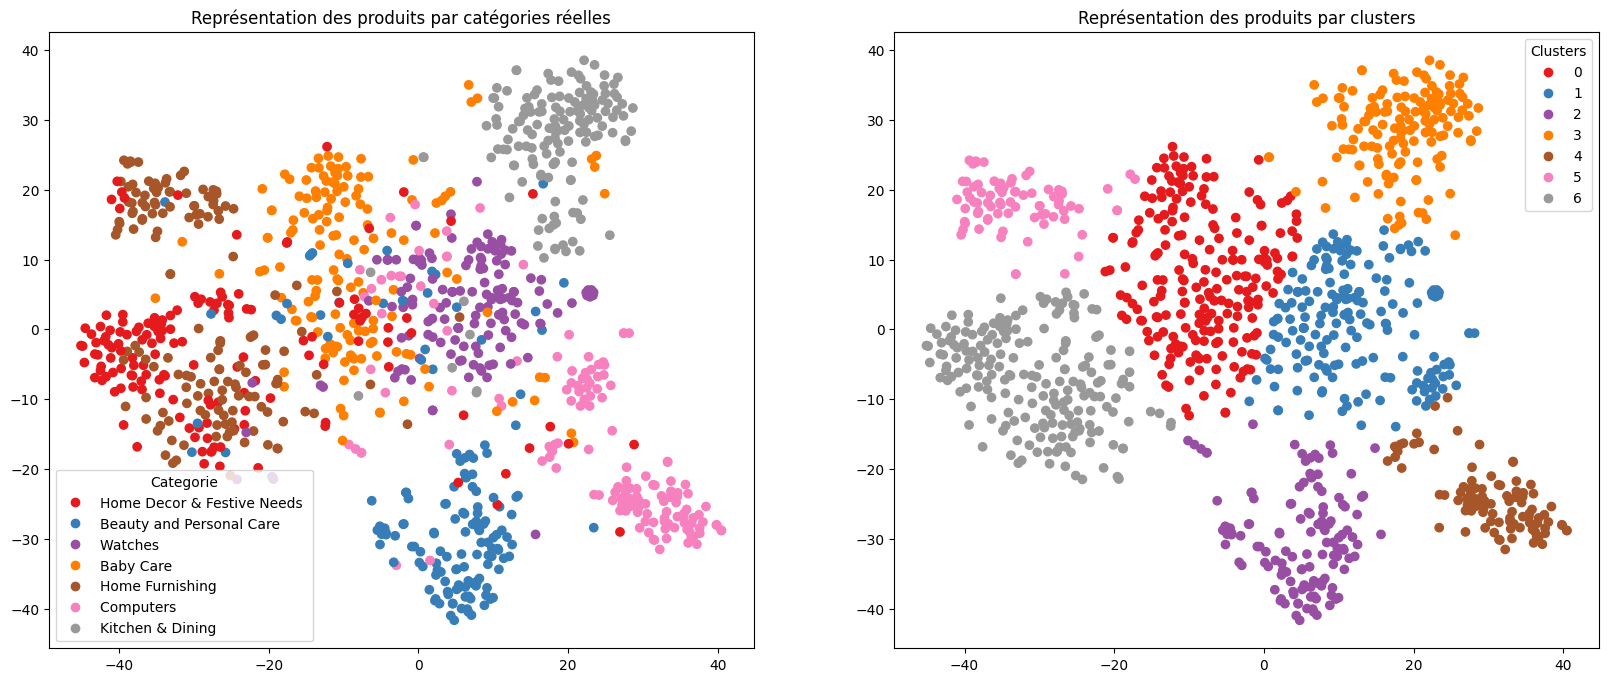

In [ ]:
X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG16", "TSNE", ARI]], axis=0)

#####**Redimmensionner PCA&t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4742


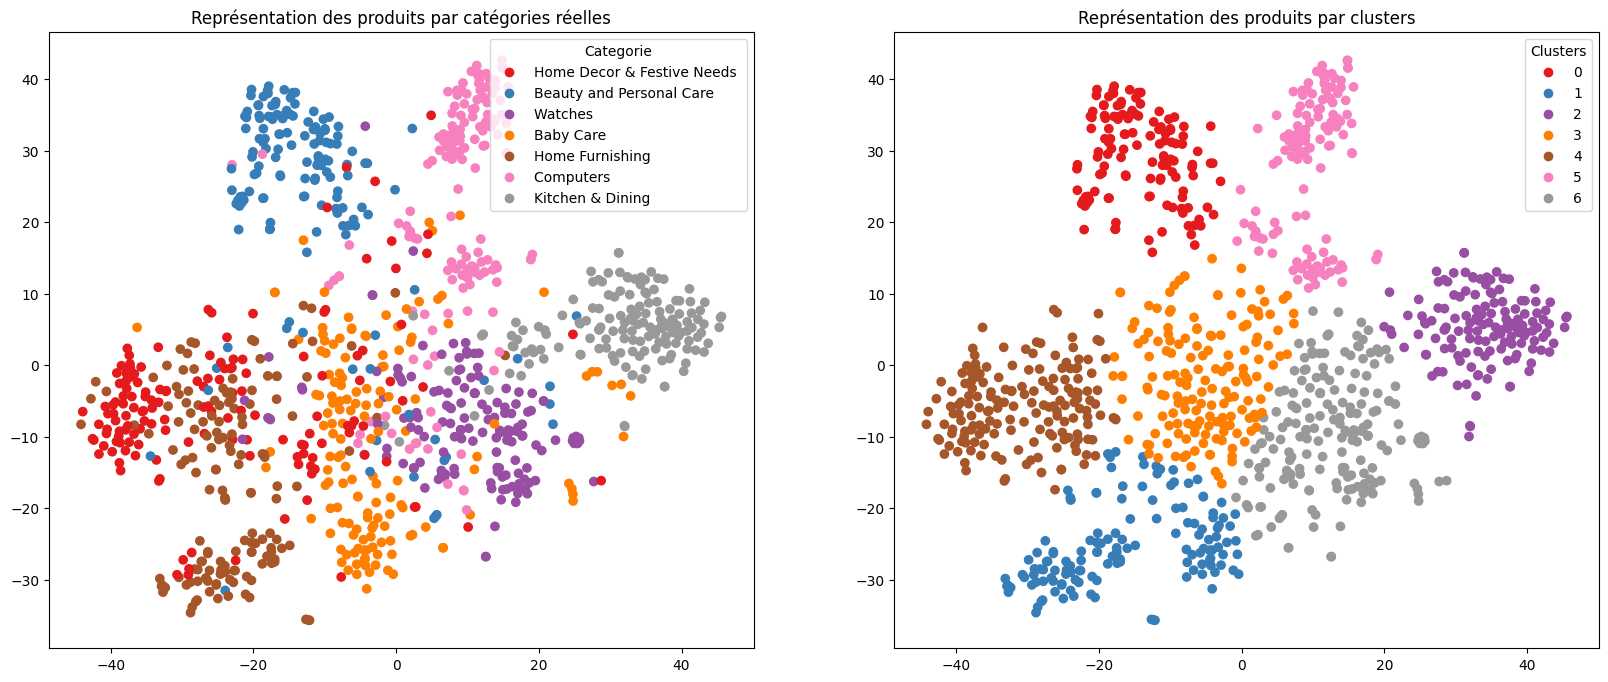

In [ ]:
X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG16", "PCA-TSNE", ARI]], axis=0)

####**ResNet** (Residual Network)

Nous allons utiliser, dans cette partie, les poids pré-entraînés sur le dataset ImageNet et ensuite extraction les caractéristiques.

In [ ]:
# Présentation du modèle
ResNet_model = ResNet50(
    weights="imagenet", input_shape=(224, 224, 3), include_top=False, pooling='avg'
)
# Résumer du modele
ResNet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

#####**Prétraitement et extraction de Caractéristiques**

In [ ]:
X = []
for image_num in tqdm(range(len(image_files))):
    img = load_img(path_to_image+ data["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = resnet.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████| 1050/1050 [00:27<00:00, 38.14it/s]


#####**Caractéristiques des images**

In [ ]:
# Caractéristiques de chaque image avec le modèle ResNet
features = ResNet_model.predict(X)

33/33 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step


In [ ]:
features.shape

(1050, 2048)

#####**Le clustering**

In [ ]:
ARI, labels = kmeans_fct(features, data['Categ_A'])

ARI_results = np.append(ARI_results, [["ResNet", "None", ARI]], axis=0)

ARI :  0.4067


#####**Redimmensionner avec ACP**

In [ ]:
pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data['Categ_A'])

ARI_results = np.append(ARI_results, [["ResNet", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 731
ARI :  0.4034


#####**Redimmensionner avec t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.5022


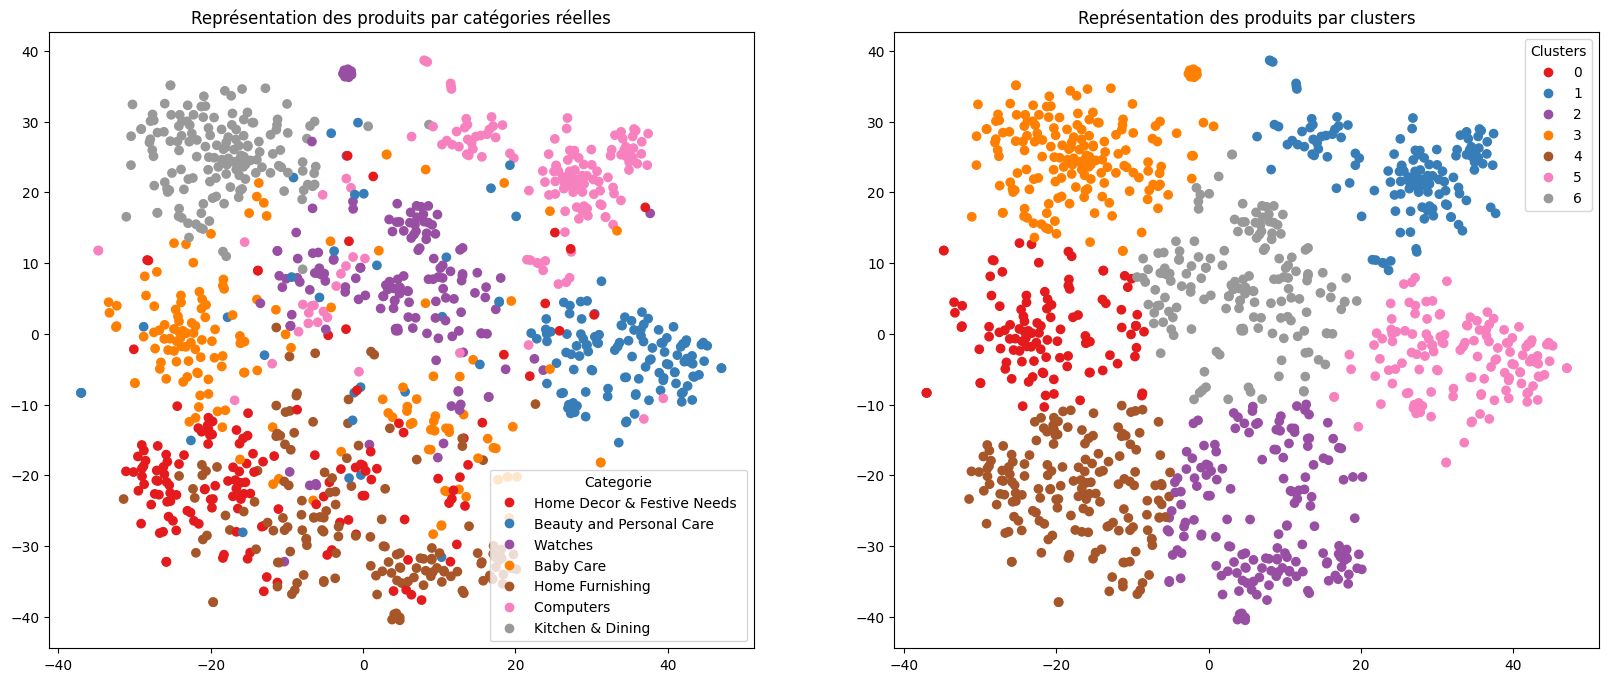

In [ ]:
X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["ResNet", "TSNE", ARI]], axis=0)

#####**Redimmensionner avec ACP et t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4837


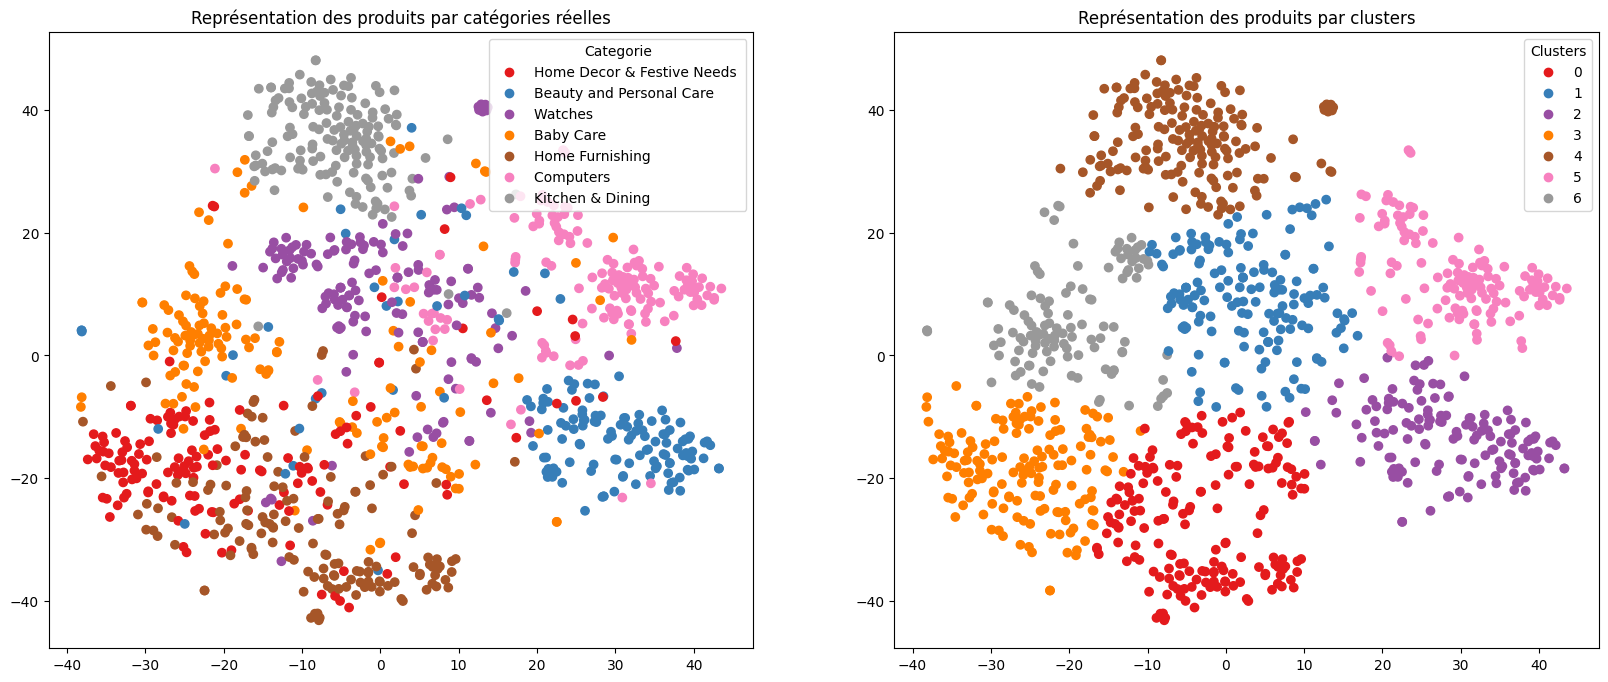

In [ ]:
X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["ResNet", "PCA-TSNE", ARI]], axis=0)

####**InceptionV3**

Dans cette partie, nous allons configurer le modèle **InceptionV3** et l'utiliser pour l'extraction des caractéristiques de nos données images.

In [ ]:
# Chargement du modèle InceptionV3 pré-entraîné avec les poids d'ImageNet sans les couches de classification finales
model_incep = InceptionV3(weights="imagenet", input_shape = (299, 299, 3), include_top = False, pooling = 'avg')
# Résumer du modèle
# model_incep.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#####**Prétraitement et extraction de Caractéristiques**

In [ ]:
X = []

for image_num in tqdm(range(len(image_files))):
    # try to extract the features and update the dictionary
    img = load_img(path_to_image+ data["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = inception_v3.preprocess_input(reshaped_img)
    X.append(imgx)

X = np.array(X)


100%|██████████| 1050/1050 [00:26<00:00, 40.38it/s]


In [ ]:
X.shape

(1050, 299, 299, 3)

#####**Les caractéristiques**

In [ ]:
# Caractéristiques des images
features = model_incep.predict(X)

33/33 ━━━━━━━━━━━━━━━━━━━━ 295s 9s/step


#####**Clustering**

In [ ]:
ARI, labels = kmeans_fct(features, data['Categ_A'])

ARI_results = np.append(ARI_results, [["InceptionV3", "None", ARI]], axis=0)

ARI :  0.4394


#####**ACP**

In [ ]:
pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, data['Categ_A'])

ARI_results = np.append(ARI_results, [["InceptionV3", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 704
ARI :  0.4335


#####**t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.5398


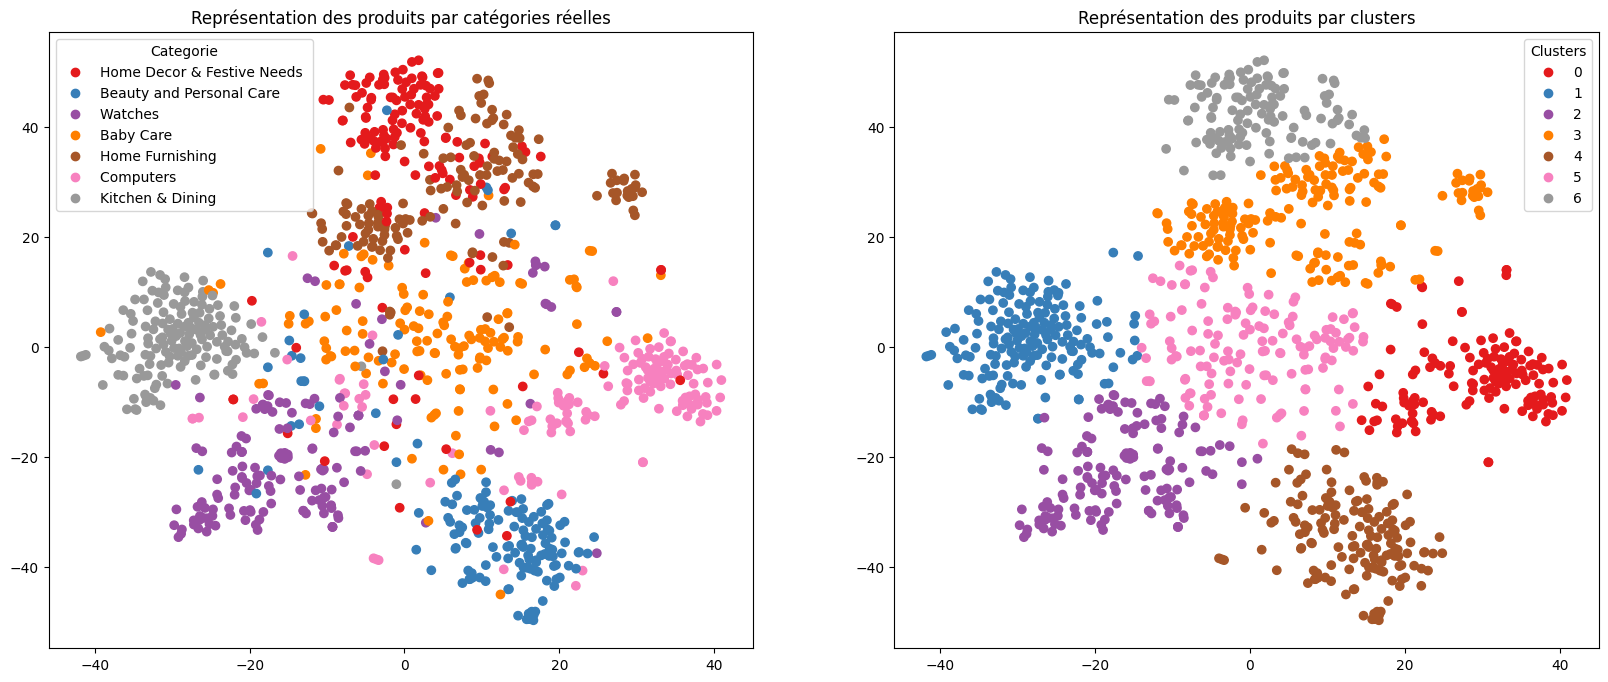

In [ ]:
X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["InceptionV3", "TSNE", ARI]], axis=0)

#####**ACP&t-SNE**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.5581


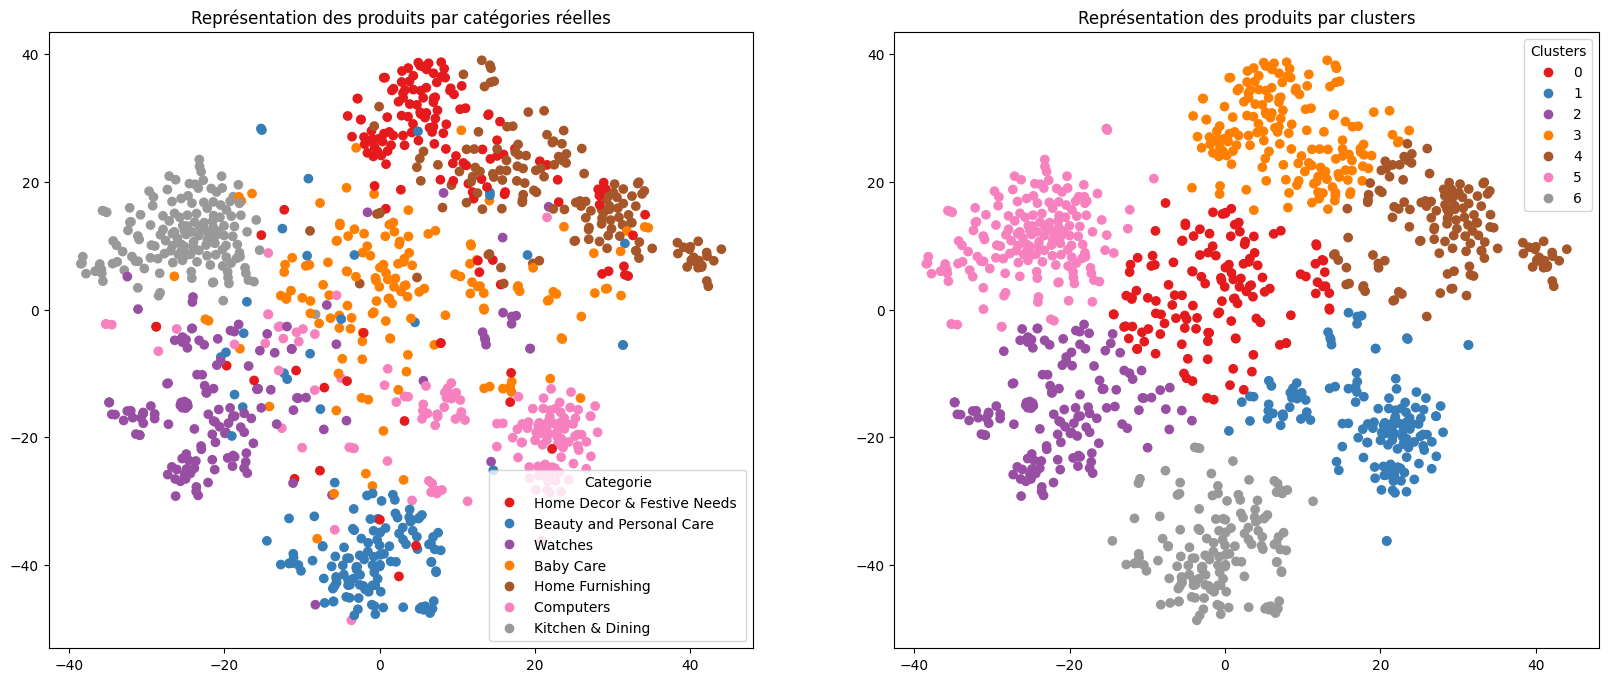

In [ ]:
X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])
reduc_visu_fct(X_reduc, data['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["InceptionV3", "PCA-TSNE", ARI]], axis=0)

#####**Matrice de confusion**

In [ ]:
conf_mat_acp_tsne = confusion_matrix(vrai_labels, labels)

[3 5 2 0 4 6 1]


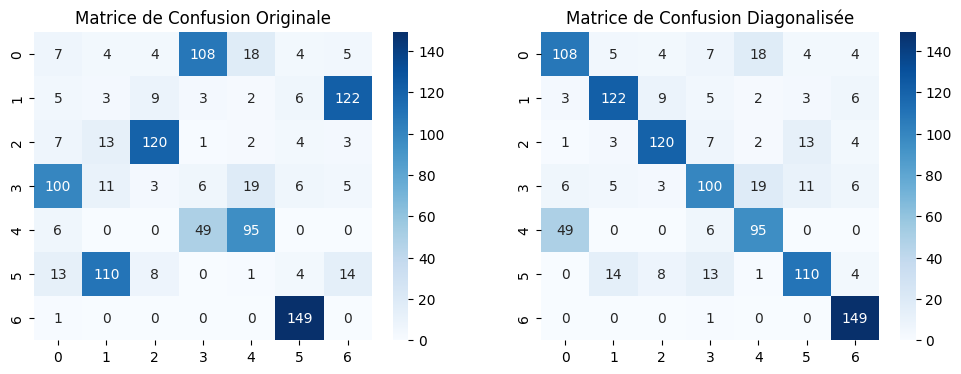

In [ ]:
df_cm = pd.DataFrame(conf_mat_acp_tsne, index = [i for i in "0123456"], columns = [i for i in "0123456"])

# Obtenir les indices des valeurs maximales par colonne
indices_max_col = np.argmax(conf_mat_acp_tsne, axis=0)
print(indices_max_col)
# Créer une matrice de confusion vide avec la même forme que l'originale
conf_mat_acp_tsne_diagonalized = np.zeros_like(conf_mat_acp_tsne)

# Réarranger les colonnes en fonction des indices max
for col in range(conf_mat_acp_tsne.shape[1]):
    row = indices_max_col[col]
    conf_mat_acp_tsne_diagonalized[:, row] += conf_mat_acp_tsne[:, col]

# Créer un DataFrame pandas pour la matrice diagonalisée
df_cm_diagonalized = pd.DataFrame(conf_mat_acp_tsne_diagonalized, index=[i for i in "0123456"], columns=[i for i in "0123456"])

# Créer une figure avec deux sous-graphiques côte à côte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # Premier sous-graphique
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Originale')

plt.subplot(1, 2, 2)  # Deuxième sous-graphique
sns.heatmap(df_cm_diagonalized, annot=True, cmap="Blues", fmt='d')
plt.title('Matrice de Confusion Diagonalisée')
plt.show();

###**Synthèse des modèles**

In [ ]:
# Génération du DF de l'ARI
ARI_results_df = pd.DataFrame( ARI_results, columns=["model", "reduction", "ARI"])
ARI_results_df['ARI'] = ARI_results_df['ARI'].astype(float)

In [ ]:
import plotly.express as px

fig = px.bar(
    ARI_results_df,
    x="model",
    y="ARI",
    color="reduction",
    barmode='group',
    title="Le score de ARI pour différents modèles et techniques réduction de dimension",
    labels={"model": "Modèles", "ARI": "Score de ARI", "reduction": "Techniques de Reduction"},
)

fig.update_xaxes(tickangle=45, ticktext=ARI_results_df["model"], tickvals=ARI_results_df["model"])

fig.show();

Le modèle d'**InceptionV3** constitue le meilleur modèle pour notre étude. Le **t-SNE** est la technique la plus performante pour la reduction de dimmensions.

####**Entrainement avec le meilleur modèle**

In [ ]:
X = []

for image_num in tqdm(range(len(image_files))):
    # try to extract the features and update the dictionary
    img = load_img(path_to_image + data["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img, mask = None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = inception_v3.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████| 1050/1050 [00:27<00:00, 37.65it/s]


**Les caractériques**

In [ ]:
features = model_incep.predict(X)

33/33 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step


**Reduction avec t-SNE**

In [ ]:
X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, data['Categ_A'])

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



ARI :  0.5581


###**Data augmentation**

####**Chargement du modèle pré-entraîné**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir les transformations
# Initialiser l'ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,          # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2,      # Translation horizontale jusqu'à 20% de l'image
    height_shift_range=0.2,     # Translation verticale jusqu'à 20% de l'image
    zoom_range=0.2,             # Zoom aléatoire entre 80% et 120%
    horizontal_flip=True,       # Retourner horizontalement les images
    fill_mode='nearest'         # Remplir les zones vides après transformation
)

**Illustration sur une image**

In [ ]:
image_path = path_to_image + '/55b85ea15a1536d46b7190ad6fff8ce7.jpg'  # chemin de l'image
image = load_img(image_path, target_size=(299, 299))  # Redimensionnée pour le modèle
image_array = img_to_array(image)
image_array = image_array.reshape((1,) + image_array.shape)

In [ ]:
image_array.shape

(1, 299, 299, 3)

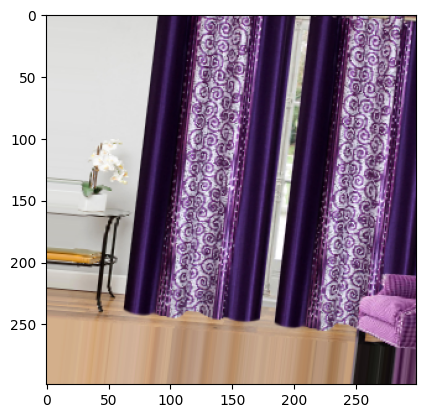

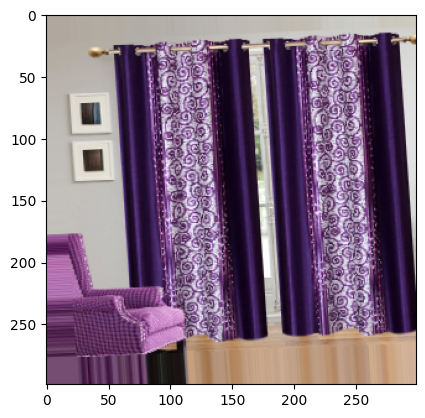

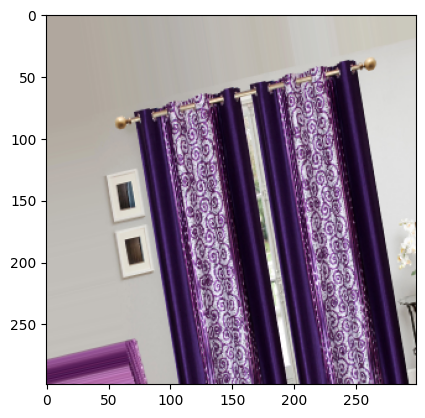

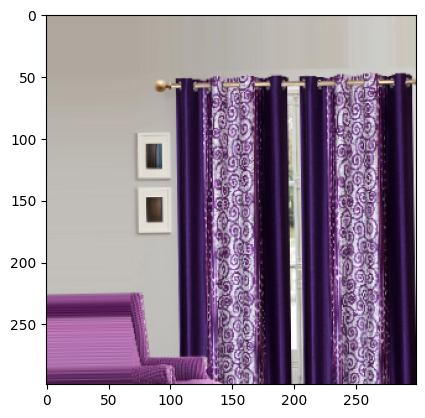

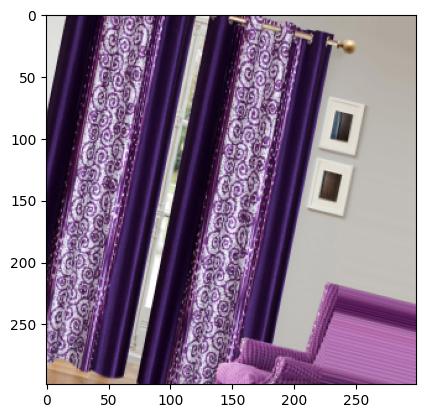

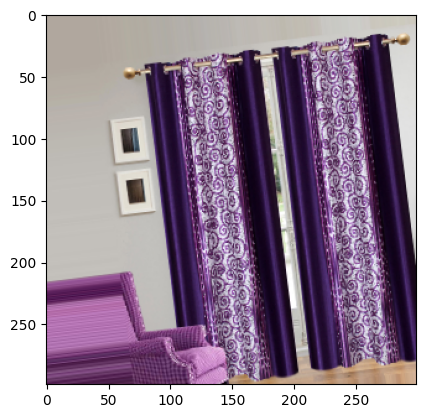

In [ ]:
# Générer et visualiser des images augmentées
i = 0
for batch in datagen.flow(image_array, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0].astype('uint8'))
    i += 1
    if i > 5:  # Afficher 5 exemples d'images augmentées
        break
plt.show();

####**Split data**

In [ ]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'Categ_A',
       'sentence_lem', 'label'],
      dtype='object')

In [ ]:
data[['image', 'Categ_A', 'label']].head(5)

image           Categ_A  label
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing       4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care       0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care       0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing       4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing       4

In [ ]:
from sklearn.model_selection import train_test_split
# Chemins
base_dir = "images/"
output_dir = "dataset/"  # Dossier où seront créés train/ et validation/

df = data.copy()
# df = data_photo.drop(columns=['Categ_A'])
# Répartition des données (70% train, 30% validation)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Categ_A'], random_state=42)


In [ ]:
# Créer les répertoires
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")

In [ ]:
for label in df['Categ_A'].unique():
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

'dataset/validation'

In [ ]:
# Copier les fichiers dans les répertoires
import shutil
def copy_files(df, src_dir, dst_dir):
    for _, row in df.iterrows():
        src_path = os.path.join(src_dir, row['image'])
        dst_path = os.path.join(dst_dir, row['Categ_A'], row['image'])
        if os.path.exists(src_path):  # Vérifier si le fichier source existe
            shutil.copy(src_path, dst_path)
        else:
            print(f"Fichier introuvable : {src_path}")

copy_files(train_df, base_dir, train_dir)
copy_files(val_df, base_dir, val_dir)

print("Les données sont organisées !")

Fichier introuvable : images/5188dd28a627807407d93549580afb74.jpg
Fichier introuvable : images/a43fbae655e5d13215b9dd65339fa9d4.jpg
Fichier introuvable : images/6b043b37c38f081d96886acb5acfbdf5.jpg
Fichier introuvable : images/7fd12776e6d62da6e1dd3cbc9882ee5f.jpg
Fichier introuvable : images/d06bb04b096c77dc3302eaf2db336f96.jpg
Fichier introuvable : images/dc777afc918f513a7253187e00a11948.jpg
Fichier introuvable : images/a541b3aba326d7749b4c086c3cea9273.jpg
Fichier introuvable : images/873a955df5a2f677a41a7efc94060e41.jpg
Fichier introuvable : images/70461caa9038cfa34d109ea056d57f5a.jpg
Fichier introuvable : images/f41761a931135c6c043c7e04abda41b0.jpg
Fichier introuvable : images/c6adf41cd378b1f6a7ac62675b060411.jpg
Fichier introuvable : images/282102897daa1c2513cf76837a8d5a4c.jpg
Fichier introuvable : images/9ff54c12cc7ffd7c1a6724477b8fea2f.jpg
Fichier introuvable : images/9bd8526e99697998cdf7dcbdfa044847.jpg
Fichier introuvable : images/5749bae8ccead7997ebf370b6b081d07.jpg
Fichier in

In [ ]:
print(train_df.shape)
print(val_df.shape)

(840, 18)
(210, 18)


In [ ]:
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

# Séparation en train et validation (80% train, 20% validation par exemple)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


**integration**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalisation
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation

In [ ]:
# Chargement des données depuis des répertoires
train_generator = train_datagen.flow_from_directory(
    'dataset/train/',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset/validation/',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)


Found 0 images belonging to 7 classes.
Found 0 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Charger le modèle pré-entraîné
base_model = InceptionV3(weights='imagenet', include_top=False)

# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # 10 classes (adapter selon vos données)

model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


ValueError: Must provide at least one structure

## **A revoir**

#####**Représentons quelques images par catégories**

Home Furnishing 
_____________


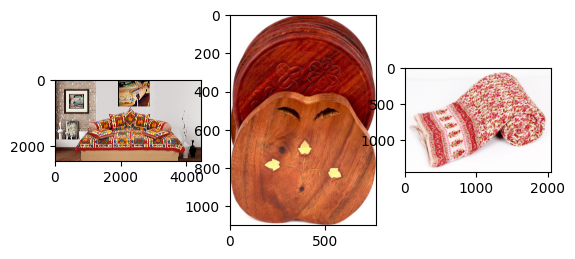

Beauty and Personal Care 
_____________


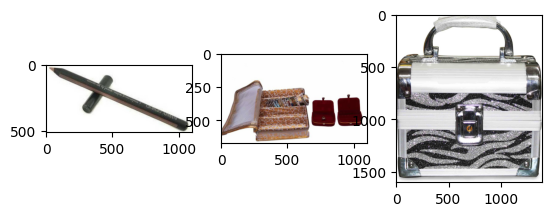

Watches 
_____________


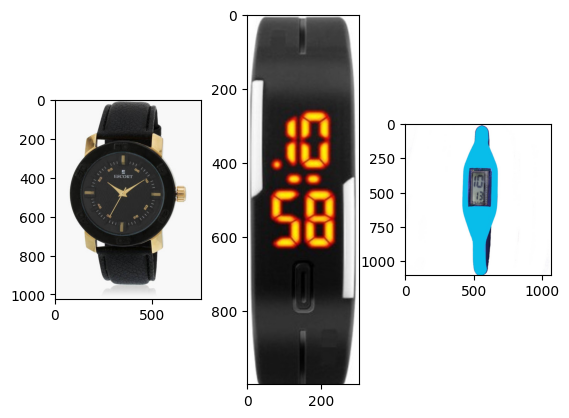

Home Decor & Festive Needs 
_____________


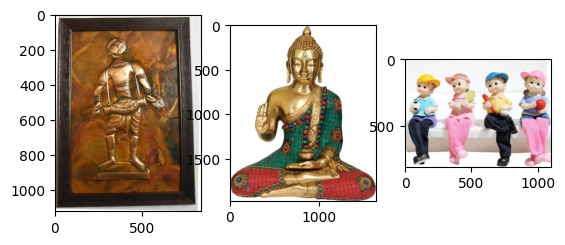

Kitchen & Dining 
_____________


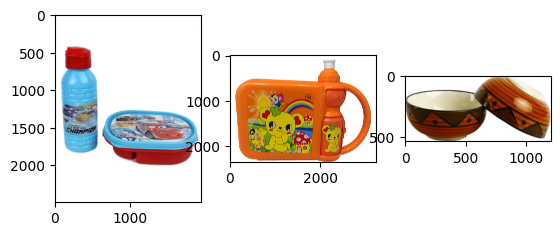

Computers 
_____________


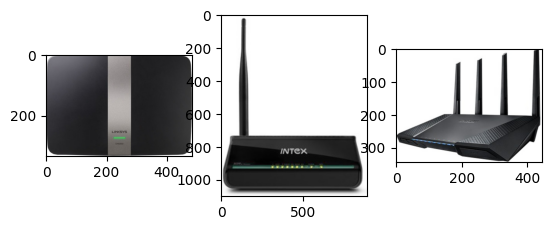

Baby Care 
_____________


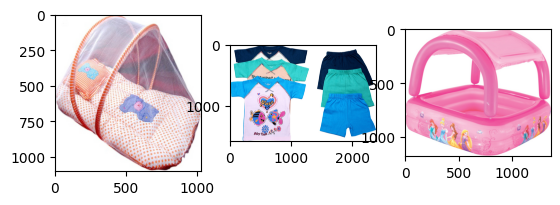

In [ ]:
# Représentons quelques images par catégories
from matplotlib.image import imread

def list_fct(name):
    list_image_name = [data["image"][i]
                       for i in range(len(data)) if data["Categ_A"][i] == name]
    return list_image_name


for categ in list(set(data['Categ_A'])):
    globals()[f'list_{categ}'] = [data["image"][i]
                                  for i in range(len(data)) if data["Categ_A"][i] == categ]

for name in list(set(data['Categ_A'])):
    print(name)
    print("_____________")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path_to_image + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show();

###**Résoudre les problèmes d'invariants**

Nous allons essayer dans cette étapes de resoudre résoudre les problèmes d'invaraiants en utilisant :

  1. detecteurs d'invariants comme sift,
  2. les trouver avec sift et les monter en hauteur,
  3. faire du kmeans et prediction pour retrouver les groupes d'origines

#####**SIFT**(Scale-Invariant Feature Transform)

On utilise, ici, **SIFT** pour extraire les points clés dans les images.

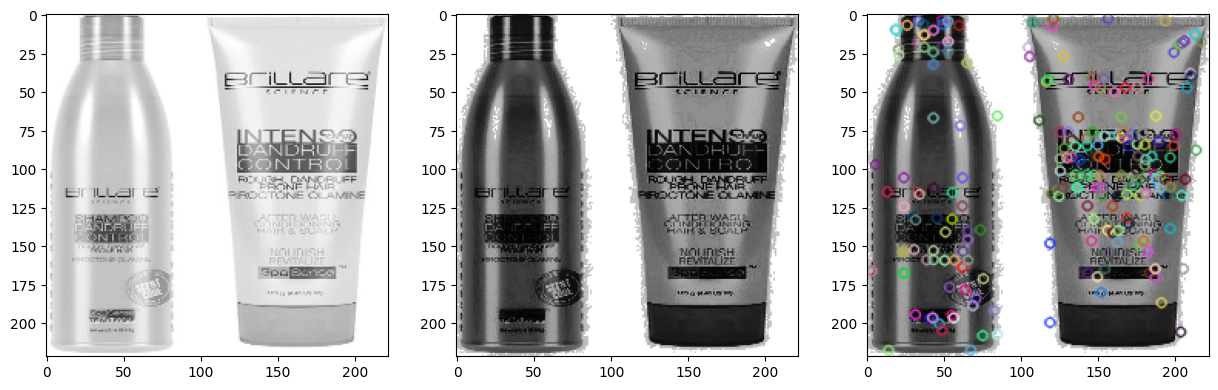

In [ ]:
# Instancier SIFT
import cv2

# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

# Charger l'image en gris(0) puis la redimensionner
image = cv2.imread(path_to_image + image_files[11], 0)
image = cv2.resize(image, (222, 222))

# Affichage de l'image originale
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(image, cmap='gray')

# Égaliser l'histogramme de l'image rendant les caractéristiques (contours, bords) plus visibles pour SIFT
image = cv2.equalizeHist(image)

plt.subplot(132)
plt.imshow(image, cmap='gray')

# Détection des points clés et calcul des descripteurs avec SIFT
kp, des = sift.detectAndCompute(image, None)

# Dessiner les points clés sur l'image
image = cv2.drawKeypoints(image, kp, image)

# Affichage de l'image avec les points clés
plt.subplot(133)
plt.imshow(image, cmap='gray')
plt.show();

#####**Détection de Caractéristiques Visuelles**

In [ ]:
# sift_keypoints = []
# temps1 = time.time()
# sift = cv2.SIFT_create()

# for image_num in tqdm(range(len(data["image"]))):
#    #if image_num%100 == 0 : print(image_num)
#     image = cv2.imread(path_to_image + data["image"][image_num], 0)
#     image = cv2.resize(image, (299, 299))
#     res = cv2.equalizeHist(image)
#     kp, des = sift.detectAndCompute(res, None)
#     sift_keypoints.append(des)

In [ ]:
# sift_keypoints_by_img = np.asarray(sift_keypoints)
# sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
# sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)

In [ ]:
# import warnings

# # Ignore tous les avertissements
# warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# sift_keypoints = [] # je stocke les descripteurs SIFT dans cette liste
# temps1 = time.time()
# sift = cv2.xfeatures2d.SIFT_create()

# images_without_descriptors = 0  # Compteur pour les images sans descripteurs

# for image_num in tqdm(range(len(data["image"]))):
#     image = cv2.imread(path_to_image + data["image"][image_num], 0)  # Lire l'image en niveaux de gris
#     image = cv2.resize(image, (299, 299))

#     res = cv2.equalizeHist(image)  # Égaliser l'histogramme de l'image
#     kp, des = sift.detectAndCompute(res, None) # Détecter les points clés et les descripteurs

#     if des is not None:  # Vérifie si descripteurs ne sont pas None
#         sift_keypoints.append(des)
#     else:
#         images_without_descriptors += 1  # Incrémente le compteur si pas de descripteurs

# # Vérifier si la liste de descripteurs n'est pas vide
# if sift_keypoints:
#     # Concaténer les descripteurs dans une liste
#     sift_keypoints_all = np.vstack(sift_keypoints)  # Utiliser vstack pour empiler verticalement
#     print("Nombre total de descripteurs : ", sift_keypoints_all.shape)
# else:
#     print("Aucun descripteur trouvé.")

# # Informations supplémentaires
# print(f"Nombre d'images traitées : {len(data['image'])}")
# print(f"Nombre d'images sans descripteurs : {images_without_descriptors}")

# duration1 = time.time() - temps1
# print("Temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")



In [ ]:

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create()

for image_num in tqdm(range(len(data["image"]))):
    image = cv2.imread(path_to_image + data["image"][image_num], 0)  # convert in gray
    image = cv2.resize(image, (299, 299))

    res = cv2.equalizeHist(image)
    kp, des = sift.detectAndCompute(res, None)

    if des is not None:  # Vérifie si descripteurs ne sont pas None
        sift_keypoints.append(des)

# Utilisation de np.concatenate directement pour combiner les descripteurs
if sift_keypoints:
    sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)

    print("Nombre de descripteurs : ", sift_keypoints_all.shape)
else:
    print("Aucun descripteur trouvé.")

duration1 = time.time() - temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


100%|██████████| 1050/1050 [01:17<00:00, 13.53it/s]


Nombre de descripteurs :  (550948, 128)
temps de traitement SIFT descriptor :            77.92 secondes


#####**Partitionnement des descripteurs**

In [ ]:
# Détermination du nombre de clusters et application du K-means

temps1 = time.time()

# Estimation du nombre de clusters à partir des descripteurs SIFT
k = int(round(np.sqrt(len(sift_keypoints_all))))  # Nombre de clusters estimés
print(f"Nombre de clusters estimés : {k}")
print(f"Création de {k} clusters de descripteurs ...")

# Clustering avec MiniBatch K-means
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

# Mesure du temps de traitement
duration1 = time.time() - temps1
print(f"Temps de traitement K-means : {duration1:.2f} secondes")


Nombre de clusters estimés : 742
Création de 742 clusters de descripteurs ...
Temps de traitement K-means : 15.52 secondes


In [ ]:
# # Creation of histograms
# def build_histogram(kmeans, des, image_num):
#     res = kmeans.predict(des)
#     hist = np.zeros(len(kmeans.cluster_centers_))
#     nb_des = len(des)
#     if nb_des == 0:
#         print("problème histogramme image  : ", image_num)
#     for i in res:
#         hist[i] += 1.0/nb_des
#     return hist


In [ ]:


# # Creation of a matrix of histograms (features)
# temps1 = time.time()

# hist_vectors = []

# for i, image_desc in enumerate(tqdm(sift_keypoints_all)):
#     #if i%100 == 0 : print(i)
#     hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
#     hist_vectors.append(hist)  # histogram is the feature vector

# im_features = np.asarray(hist_vectors)

# duration1 = time.time()-temps1
# print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

In [ ]:
# Création des histogrammes
def build_histogram(kmeans, des, image_num):
    # Assurez-vous que des est un tableau 2D
    if des.ndim == 1:
        des = des.reshape(1, -1)  # Redimensionner en tableau 2D si nécessaire

    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)

    if nb_des == 0:
        print("Problème histogramme image : ", image_num)

    for i in res:
        hist[i] += 1.0 / nb_des  # Normaliser l'histogramme

    return hist

# Création d'une matrice d'histogrammes (features)
temps1 = time.time()

hist_vectors = []

for i, image_desc in enumerate(tqdm(sift_keypoints_all)):
    hist = build_histogram(kmeans, image_desc, i)  # Calcule l'histogramme
    hist_vectors.append(hist)  # L'histogramme est le vecteur de caractéristiques

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création des histogrammes : ", f"{duration1:.2f} secondes")


100%|██████████| 550948/550948 [04:31<00:00, 2031.67it/s]


Temps de création des histogrammes :  277.03 secondes


In [ ]:
histogram_sum = np.sum(hist_vectors)

In [ ]:
print(type(sift_keypoints_all))

<class 'numpy.ndarray'>


In [ ]:
len(hist_vectors)

550948

#####**Application du Clustering K-means**

In [ ]:
ARI_results = np.empty(shape=[0, 3])

ARI, labels = kmeans_fct(im_features, data['Categ_A'])

ARI_results = np.append(ARI_results, [["SIFT", "None", ARI]], axis=0)